# Black Friday Sales Prediction

## Data Exploration

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import seaborn as sns

In [3]:
from sklearn import preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split



from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [3]:
#read in data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.shape

(550068, 12)

In [4]:
def data_summary(d):
    '''
    function that gets the summary information on dataframe
    '''
    number_nan = [d[col].isnull().sum() for col in d.columns]
    number_distinct = [d[col].nunique() for col in d.columns]
    distinct_val = [d[col].unique() for col in d.columns]
    data_type = [type(d[col][0]) for col in d.columns]
    data_summary = pd.DataFrame({'columns': d.columns,
                                 'number_nan': number_nan,
                                 'number_distinct': number_distinct,
                                 'distinct_val': distinct_val,
                                'data_type': data_type})
    data_summary.set_index('columns')
    return data_summary

### Basic Stats and Data Visualization

**Basic Statistics**

In [5]:
data_summary(train_df)

,columns,number_nan,number_distinct,distinct_val,data_type
0,User_ID,0,5891,"[1000001, 1000002, 1000003, 1000004, 1000005, ...",<class 'numpy.int64'>
1,Product_ID,0,3631,"[P00069042, P00248942, P00087842, P00085442, P...",<class 'str'>
2,Gender,0,2,"[F, M]",<class 'str'>
3,Age,0,7,"[0-17, 55+, 26-35, 46-50, 51-55, 36-45, 18-25]",<class 'str'>
4,Occupation,0,21,"[10, 16, 15, 7, 20, 9, 1, 12, 17, 0, 3, 4, 11,...",<class 'numpy.int64'>
5,City_Category,0,3,"[A, C, B]",<class 'str'>
6,Stay_In_Current_City_Years,0,5,"[2, 4+, 3, 1, 0]",<class 'str'>
7,Marital_Status,0,2,"[0, 1]",<class 'numpy.int64'>
8,Product_Category_1,0,20,"[3, 1, 12, 8, 5, 4, 2, 6, 14, 11, 13, 15, 7, 1...",<class 'numpy.int64'>
9,Product_Category_2,173638,17,"[nan, 6.0, 14.0, 2.0, 8.0, 15.0, 16.0, 11.0, 5...",<class 'numpy.float64'>


In [6]:
train_df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


**Data Visualizations**

In [6]:
def count_purchase(col):
    %matplotlib inline
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 5))

    train_df.groupby([col])['User_ID'].count().sort_values(ascending=False).plot.bar(ax = ax1)
    ax1.set_ylabel('Count of distinct customers')
    train_df.groupby([col])['Purchase'].sum().sort_values(ascending=False).plot.bar(ax = ax2)
    ax2.set_ylabel('Purchase amount')

Occupations

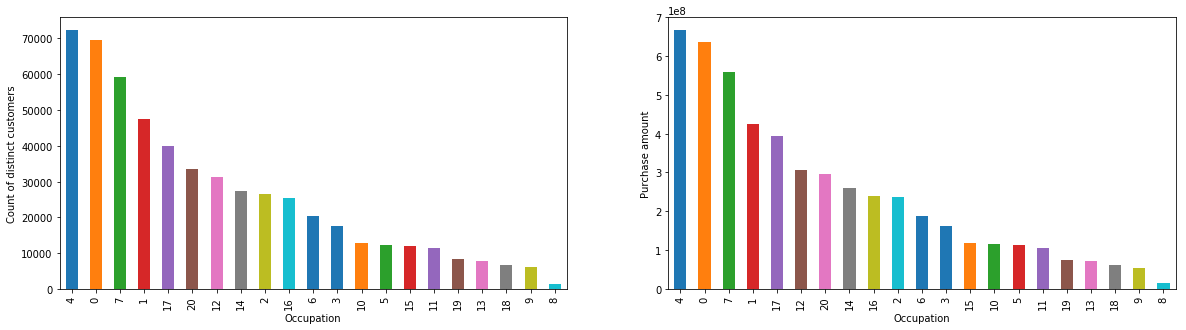

In [8]:
count_purchase('Occupation')
plt.savefig('Occupation.png', dpi=300)

Age and Gender

Text(0, 0.5, 'Purchase $ per person')

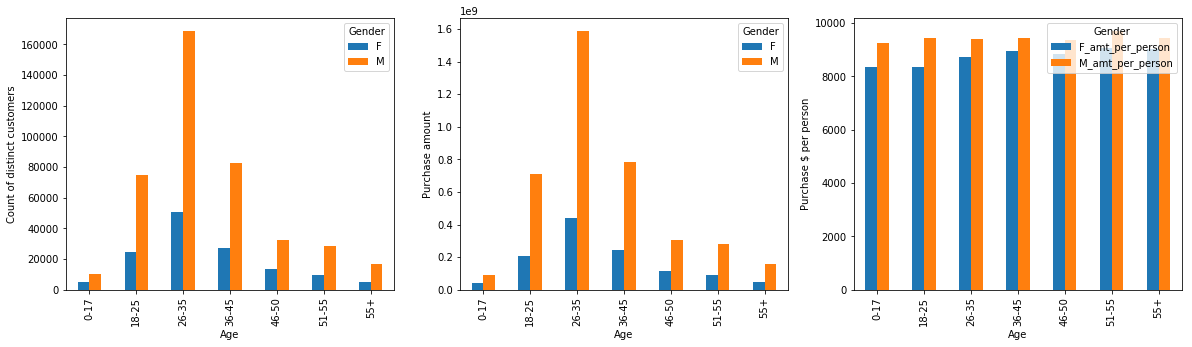

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (20, 5))

t1 = train_df.groupby(['Gender','Age'])['User_ID'].count().unstack(0) # number of customers
t1.plot.bar(ax = ax1)
ax1.set_ylabel('Count of distinct customers')

t2 = train_df.groupby(['Gender','Age'])['Purchase'].sum().unstack(0) # total purchase amount
t2.plot.bar(ax = ax2)
ax2.set_ylabel('Purchase amount')

t3 = pd.merge(t1, t2, left_index = True, right_index = True)
t3 = t3.rename(index=str, columns={"F_x":"F_count", "M_x":"M_count", "F_y":"F_amt", "M_y":"M_amt"})
t3['F_amt_per_person'] = t3['F_amt']/t3['F_count']
t3['M_amt_per_person'] = t3['M_amt']/t3['M_count']
t3[['F_amt_per_person', 'M_amt_per_person']].plot.bar(ax = ax3)
ax3.set_ylabel('Purchase $ per person')

plt.savefig('Age.png', dpi=300)

购买力差不多

Marital Status

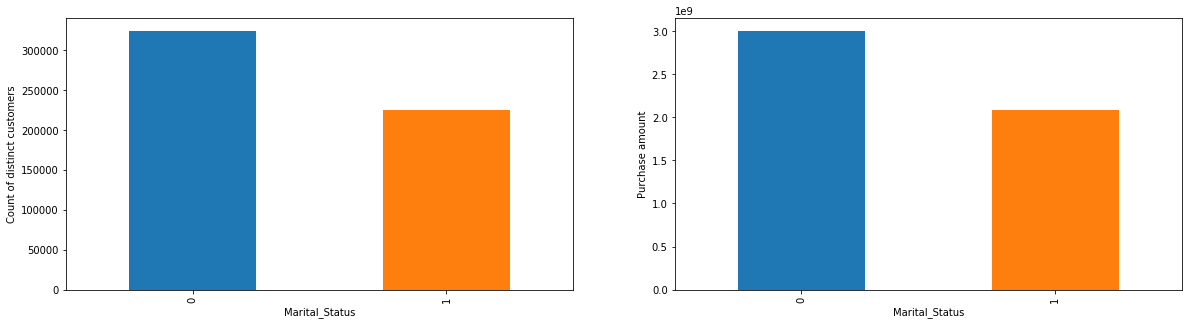

In [10]:
count_purchase('Marital_Status')
plt.savefig('Marital_Status.png', dpi=300)

**Mutual Information**

In [11]:
d = {}
mi_lst = []
for col in train_df.columns[:-1]:
    mi_lst.append(normalized_mutual_info_score(train_df[col], train_df.iloc[:,-1]))

d = {'columns': train_df.columns[:-1], 'MI': mi_lst}
d_df = pd.DataFrame(d)
d_df.sort_values(by = ['MI'], ascending=False)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


,columns,MI
10,Product_Category_3,0.682315
0,User_ID,0.483649
9,Product_Category_2,0.456969
1,Product_ID,0.443597
8,Product_Category_1,0.393285
4,Occupation,0.055820
3,Age,0.026489
6,Stay_In_Current_City_Years,0.018523
5,City_Category,0.012839
2,Gender,0.010541


Gender and Marital_Status has the lowest mutual information with our target 'Purchase'.

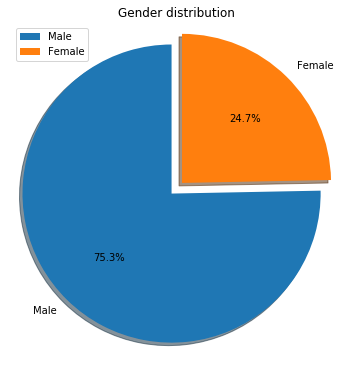

In [70]:
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(train_df['Gender'].value_counts(), explode=explode,labels=['Male','Female'], autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.title('Gender distribution')
plt.show()

Text(0.5, 1.0, 'blox plot for gender and purchase')

<Figure size 864x504 with 0 Axes>

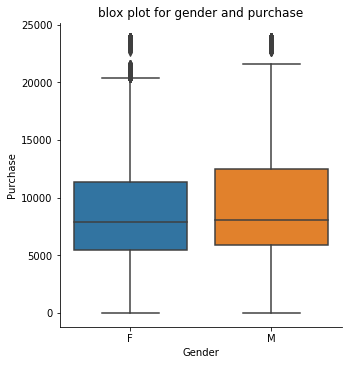

In [59]:
plt.figure(figsize=(12,7))
sns.catplot(x='Gender',y='Purchase', data=train_df,kind='box')
plt.title("blox plot for gender and purchase")

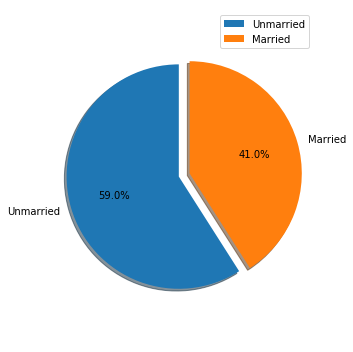

In [62]:
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(train_df['Marital_Status'].value_counts(), explode=explode,labels=['Unmarried','Married'], autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
#plt.title('Marital status distribution')
plt.show()

In [65]:
married = np.mean(train_df[train_df.Marital_Status== 1].Purchase)
unmarried = np.mean(train_df[train_df.Marital_Status== 0].Purchase)
df = pd.DataFrame([married,unmarried])

Text(0.5, 0, 'Marital status')

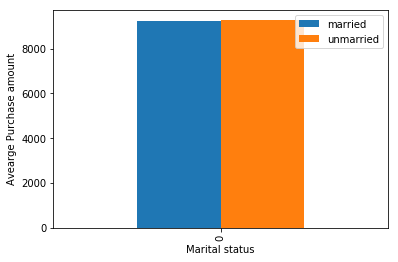

In [66]:
from itertools import cycle, islice
df = pd.DataFrame({"married":[married],"unmarried":[unmarried]})
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = df.plot.bar()
ax.set_ylabel('Avearge Purchase amount')
ax.set_xlabel('Marital status')

Text(0.5, 0, 'Marital status')

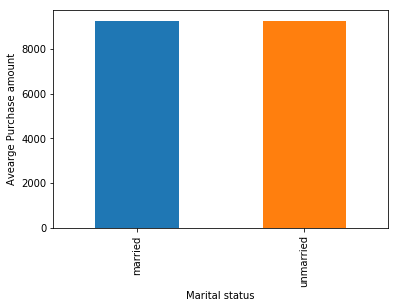

In [67]:
df = pd.DataFrame({'marital status':['married', 'unmarried'], 'average purchase per transaction':[married,unmarried]})
ax = df.plot.bar(x='marital status', y='average purchase per transaction',legend=False)
ax.set_ylabel('Avearge Purchase amount')
ax.set_xlabel('Marital status')

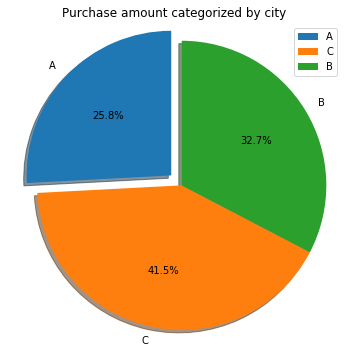

In [69]:
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(train_df.groupby('City_Category')['Purchase'].sum(),explode=explode, labels=train_df['City_Category'].unique(), autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.title("Purchase amount categorized by city ")
plt.tight_layout()
plt.legend()
plt.show()

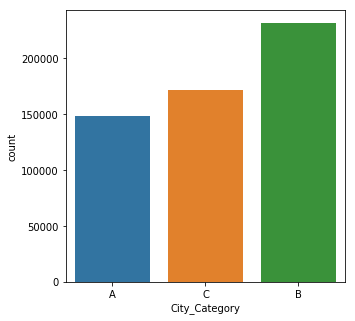

In [71]:
fig1, ax1 = plt.subplots(figsize=(5,5))
sns.countplot(train_df['City_Category'])

Text(0.5, 1.0, 'Number of transactions in different cities')

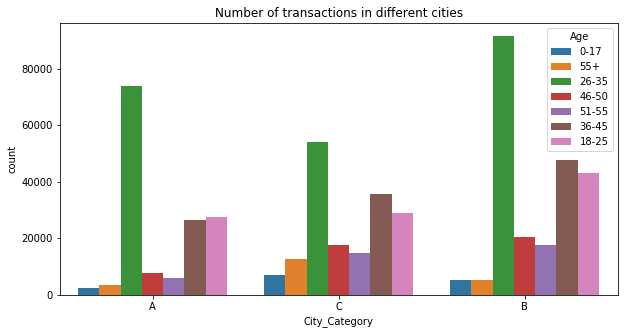

In [74]:
fig1, ax1 = plt.subplots(figsize=(10,5))
sns.countplot(train_df['City_Category'],hue=train_df['Age'])
plt.title ("Number of transactions in different cities")

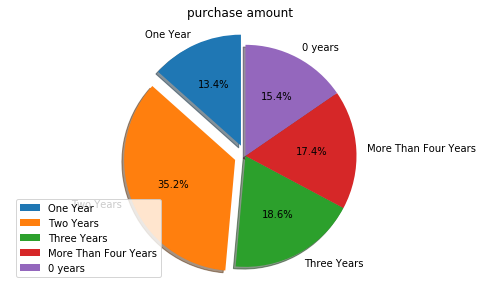

In [77]:
labels=['One Year','Two Years','Three Years','More Than Four Years','0 years']
explode = (0.1, 0.1,0,0,0)
fig1, ax1 = plt.subplots(figsize=(7,4))
ax1.pie(train_df.groupby('Stay_In_Current_City_Years')['Purchase'].sum(),explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.title("purchase amount")
plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


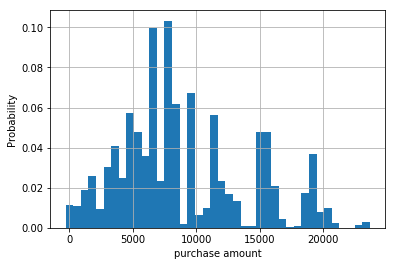

In [78]:
#np.histogram(train_df.Purchase)
results, edges = np.histogram(train_df.Purchase, 40,normed = True)
binWidth = edges[1] - edges[0]
plt.bar(edges[:-1], results*binWidth, binWidth)
plt.ylabel('Probability')
plt.xlabel('purchase amount')


plt.grid(True)

Text(0.5, 1.0, 'blox plot for purchase amount')

<Figure size 144x216 with 0 Axes>

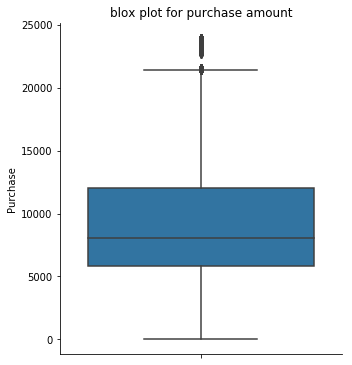

In [79]:
plt.figure(figsize=(2,3))
sns.catplot(y='Purchase', data=train_df,kind='box')
plt.title("blox plot for purchase amount")

### Data Cleaning

In [7]:
train_new = train_df.copy()

In [8]:
def train_test(data, test_size):
    test_index = np.random.choice(data.index, size=int(data.shape[0]*test_size), replace=False)
    train_index =  list(set(data.index) - set(test_index))
    
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    return(train,test)

In [9]:
train, test  = train_test(train_df, test_size = 0.1)

In [10]:
# 1. Transform 'Product_ID'
### fill in Product_Count
d_count = Counter(train_df['Product_ID'].tolist()) # dictionary of 'Product_ID': count

def count_id(ID):
    '''
    fill Product_Count with the number of product for that Product_ID
    '''
    if ID in d_count:
        return d_count[ID]
    else:
        return 0 # if not exist in d_count, fill with 0

### Fill in Product_Mean
temp = train_df.groupby('Product_ID')['Purchase'].mean()
d_purchase = dict(zip(temp.index.tolist(), temp.values.tolist())) # dictionary of 'Product_ID': count

def amount_id(ID):
    '''
    fill Product_Mean with the mean dollar value of product for that Product_ID
    '''
    if ID in d_purchase:
        return d_purchase[ID]
    else:
        return np.mean(list(d_purchase.values())) # if not exist in d_purchase, fill with mean value

In [11]:
def transform(data, convert_category = False):
    '''
    To transform the training and testing data for use
    arg:
        data (the dataframe you want to transform)
    '''
    data_ready = data.copy()
    
    # 1. Transform 'Product_ID'
    ## add two empty columns to dataframe
    data_ready = data_ready.assign(Product_Mean=np.nan,Product_Count=np.nan)
    
    ### fill in Product_Count
    data_ready['Product_Count'] = data_ready['Product_ID'].apply(count_id)
    
    ### Fill in Product_Mean
    data_ready['Product_Mean'] = data_ready['Product_ID'].apply(amount_id)
       
    
    # 2. Convert(encode) nominal variables
    genders = pd.get_dummies(data_ready['Gender'], drop_first = True, prefix = 'Gender')
    data_ready = pd.merge(data_ready, genders, left_index=True, right_index = True)

    occupations = pd.get_dummies(data_ready['Occupation'], drop_first = True, prefix = 'Occupation')
    data_ready = pd.merge(data_ready, occupations, left_index=True, right_index = True)

    cities = pd.get_dummies(data_ready['City_Category'], drop_first = True, prefix = 'City_Category')
    data_ready = pd.merge(data_ready, cities, left_index=True, right_index = True)

    maritial = pd.get_dummies(data_ready['Marital_Status'], drop_first = True, prefix = 'Marital_Status')
    data_ready = pd.merge(data_ready, maritial, left_index=True, right_index = True)
    
    
    # 3. Convert ordinal variables
    ## 'Age':
    age_dict={}
    for (i,u) in enumerate(['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']):
        age_dict[u] = i

    ## 'Stay_In_Current_City_Years':
    years_dict = {}
    for (i,u) in enumerate(['0', '1', '2', '3', '4+']):
        years_dict[u] = i
        
    data_ready['Age'] = data_ready['Age'].map(age_dict)
    data_ready['Stay_In_Current_City_Years'] = data_ready['Stay_In_Current_City_Years'].map(years_dict)
    
    
    
    # 4. Convert Product_Category
    if convert_category == False:
        ## do not convert category data (e.g. tree models)
        ## fill all empty cells with category 0
        data_ready[['Product_Category_1', 'Product_Category_2', 
                   'Product_Category_3']]=data_ready[['Product_Category_1', 
                                                     'Product_Category_2', 'Product_Category_3']].fillna(0)
        
    else:
        ## convert category data
        data_ready.Product_Category_1 = data_ready.Product_Category_1.astype(float)
        t1 = pd.get_dummies(data_ready['Product_Category_1'], drop_first = True)
        t2 = pd.get_dummies(data_ready['Product_Category_2'])
        t3 = pd.get_dummies(data_ready['Product_Category_3'])
        t = t1.add(t2,fill_value=0) 
        t = t.add(t3,fill_value=0).astype(int)
        
        pc = ['Product_Category' + str(i) for i in range(2,21)]
        cols = dict(zip(np.array(range(2,21)).astype(float), pc))
        t = t.rename(columns=cols)
        data_ready = pd.merge(data_ready, t,left_index=True, right_index = True)
        
    # 5. Drop unnecessary columns
    if convert_category == False:
        data_ready = data_ready.drop(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 
                                  'City_Category', 'Stay_In_Current_City_Years','Marital_Status'], axis = 1)
    else:
        data_ready = data_ready.drop(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 
                                  'City_Category', 'Stay_In_Current_City_Years','Marital_Status',
                                  'Product_Category_1', 'Product_Category_2', 'Product_Category_3'], axis = 1)
    
    # reset indexes to be continuous
    data_ready = data_ready.reset_index(drop=True)
    
    return data_ready

Product ID

In [334]:
train_df['Product_ID'].nunique()

3631

- Product ID has one of the most mutual information with our target values - 'purchase'.
- There are 3631 unique 'Product_ID' in the dataset. Thus, one-hot encoding is not an option.
- Information that 'Product_ID' represents:
    - the mean (average) values of this kind of product
    - how many of this kind of products do people buy
- Thus, we can convert 'Product_ID' into two different columns: 'Product_Mean' (average $ value of this kind of product) and 'Product_Count' (total amount of this kind of products people buy)

**Correlations**

In [17]:
d = train_new[['Gender','Age','Occupation','City_Category',
     'Stay_In_Current_City_Years','Marital_Status','Purchase']].corr()
d.style.background_gradient().set_precision(2)

plt.savefig('correlation.png', dpi=300)

,Occupation,Marital_Status,Purchase
Occupation,1,0.024,0.021
Marital_Status,0.024,1,-0.00046
Purchase,0.021,-0.00046,1


**Drop unnecessary columns**

**Check out the data-cleaning results**

In [352]:
data_summary(train_new).T

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
columns,User_ID,Purchase,Gender_M,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,Product_Category_11,Product_Category_12,Product_Category_13,Product_Category_14,Product_Category_15,Product_Category_16,Product_Category_17,Product_Category_18,Product_Category_19,Product_Category_20
data_type,<class 'numpy.int64'>,<class 'numpy.int64'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,...,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.uint8'>,<class 'numpy.int64'>,<class 'numpy.int64'>
distinct_val,"[1000001, 1000002, 1000003, 1000004, 1000005, ...","[8370, 15200, 1422, 1057, 7969, 15227, 19215, ...","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]",...,"[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]","[0, 1]"
number_distinct,5891,18105,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
number_nan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [353]:
train_new.describe()

,User_ID,Purchase,Gender_M,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,Product_Category_11,Product_Category_12,Product_Category_13,Product_Category_14,Product_Category_15,Product_Category_16,Product_Category_17,Product_Category_18,Product_Category_19,Product_Category_20
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,...,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,9263.968713,0.753105,0.086218,0.048336,0.032087,0.131453,0.022137,0.037005,0.107501,...,0.073129,0.034034,0.039157,0.136454,0.131180,0.155833,0.055629,0.019132,0.002914,0.004636
std,1.727592e+03,5023.065394,0.431205,0.280687,0.214475,0.176231,0.337895,0.147130,0.188773,0.309750,...,0.260349,0.181317,0.193968,0.343270,0.337598,0.362698,0.229205,0.136990,0.053905,0.067929
min,1.000001e+06,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.001516e+06,5823.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.003077e+06,8047.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.004478e+06,12054.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.006040e+06,23961.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Modeling: Regression

Baseline functions

In [12]:
def rmse(y_test, y_pred):
    '''
    Calculate rmse function
    '''
    return math.sqrt(np.mean((y_pred - y_test) ** 2))

In [13]:
def train_model(model, X_train,  y_train,  param_grid={}, splits=4):

    '''
    Modeling and evaluation function

    args:
        - model: regressor object, e.g. DecisionTreeRegressor()
        - param_grid: a dictionary with possible parameters choices
        - splits: number of k-folds splits
    ''' 
    
    # create cross-validation method
    kfolds = KFold(n_splits = splits)

    ## perform cross-validation
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, cv=kfolds,
                           scoring='neg_mean_squared_error', return_train_score=True)

    # search the grid
    gsearch.fit(X_train,y_train)

    # extract best model from the grid
    best_model = gsearch.best_estimator_  
    best_score = gsearch.best_score_
    
    # print stats on model performance         
    print('----------------------')
    print(best_model)
    print('----------------------')
    print('rmse=',math.sqrt(-best_score))
    
    return best_model, best_score

### Define cross-validation and dictionary to store optimal models and scores

In [14]:
# places to store optimal models and scores
opt_models = dict()
model_lst = []
score_lst = []

# no. k-fold splits
splits=4

### Prepare Data for Training

In [15]:
# data with no transforming 
train_new = transform(train,False)
test_new = transform(test,False)

X_train_new = train_new.drop("Purchase",1)
Y_train_new = train_new["Purchase"]

In [16]:
# data with transforming 
train_new2 = transform(train,True)
test_new2 = transform(test,True)

X_train_new2 = train_new2.drop("Purchase",1)
Y_train_new2 = train_new2["Purchase"]

### 1. Baseline Model

**Assuming the mean value for a certain product does not change over the years, our predicted purchase dollar amount will be the mean value for that product.**

**This means our predicted purchase dollar amount will be equal to ’Product_Mean‘.**

In [17]:
y_pred = X_train_new.Product_Mean
print('Baseline Model (rmse): ' + str(round(rmse(Y_train_new, y_pred), 3)))

Baseline Model (rmse): 2647.15


Obviously, this model did not do a good job in predicting the accurate purchase amount. We then turn to other possible models.

### 2.1 Linear Regression

In [18]:
model = 'Linear Regression'
opt_models[model] = linear_model.LinearRegression()
opt_models[model], cv_score= train_model(opt_models[model],X_train_new2,Y_train_new2,splits=splits)

model_lst.append(model)
score_lst.append(np.sqrt(-cv_score))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


----------------------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
----------------------
rmse= 2641.0184648860013


In [22]:
opt_models

{'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False)}

In [21]:
## calculate other metrics: R-squared and adjusted R-squared
y_pred = opt_models['Linear Regression'].predict(X_train_new2)
SS_Residual = sum((Y_train_new2-y_pred)**2)
SS_Total = sum((Y_train_new2-np.mean(Y_train_new2))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(Y_train_new2)-1)/(len(Y_train_new2)-X_train_new2.shape[1]-1)
print('r_squared:          ', round(r_squared, 5))
print('adjusted_r_squared: ', round(adjusted_r_squared, 5))

r_squared:           0.72347
adjusted_r_squared:  0.72345


Because R-squared grows as number of predictors grow, we find adjusted R-squared a better metric to compare models. From the values we observed that there isn't a big difference between R-squared and adjusted R-squared.

Text(0.5, 1.0, 'Residual vs. True Value')

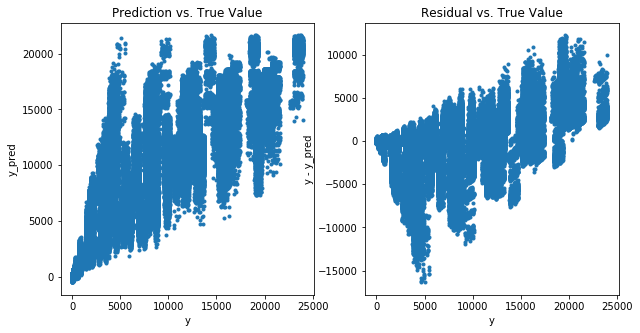

In [28]:
# plot y_test, y_pred, and residuals
y_pred = opt_models[model].predict(X_train_new2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(Y_train_new2,y_pred,'.')
plt.xlabel('y')
plt.ylabel('y_pred');
plt.title('Prediction vs. True Value')

plt.subplot(1,2,2)
plt.plot(Y_train_new2, Y_train_new2-y_pred,'.')
plt.xlabel('y')
plt.ylabel('y - y_pred');
plt.title('Residual vs. True Value')

In [94]:
## calculate VIF (detect multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame({'VIF': [variance_inflation_factor(X_train_new.values, j) for j in range(X_train_new.shape[1])]},
index = X_train_new.columns)

,Product_Category_1,Product_Category_2,Product_Category_3,Product_Mean,Product_Count,Gender_M,Occupation_1,Occupation_2,Occupation_3,Occupation_4,...,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_B,City_Category_C,Marital_Status_1
VIF,2.827224,2.125982,1.729012,6.095039,3.039555,3.903561,1.475454,1.261264,1.164619,1.701786,...,1.280113,1.13278,1.279799,1.465088,1.078741,1.086382,1.337905,2.369886,2.116925,1.715293


In [95]:
vif

,VIF
Product_Category_1,2.827224
Product_Category_2,2.125982
Product_Category_3,1.729012
Product_Mean,6.095039
Product_Count,3.039555
Gender_M,3.903561
Occupation_1,1.475454
Occupation_2,1.261264
Occupation_3,1.164619
Occupation_4,1.701786


By computing the VIF of all predictors, we found that the VIF score for 'Product_Mean' is particularity high. This makes sense because 'Product_Mean' is calculated by using values from other predictors. Thus, there exists strong multicollinearity for some predictors in our data set.

### 2.2 Lasso

In [29]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = [0.5e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 1]
param_grid = {'alpha': alph_range}

opt_models[model], cv_score = train_model(opt_models[model], X_train_new2, Y_train_new2, param_grid=param_grid, splits=splits)

model_lst.append(model)
score_lst.append(np.sqrt(-cv_score))

----------------------
Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
----------------------
rmse= 2641.155114101768


As we can see, α  = 0.5 gives the lowest Root Mean Squared Error of the model.

### 3. Random Forest

In [ ]:
model = 'Random Forest'

opt_models[model] = RandomForestRegressor(verbose = 10)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

opt_models[model], cv_score = train_model(opt_models[model], X_train_new,Y_train_new, param_grid=param_grid, splits=splits)

model_lst.append(model)
score_lst.append(np.sqrt(-cv_score))

### 4. XGBoost

In [36]:
model = 'XGB'
opt_models[model] = XGBRegressor()

eta = [0.01, 0.1]
n_estimators = [100, 200, 500, 1000]
max_depth = range(3,10,2)
min_child_weight = range(1,6,2)
gamma = [i/10.0 for i in range(0,5)]
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree = [i/10.0 for i in range(6,10)]
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
eval_metric = ['rmse']

param_grid = {'eta': [0.01],
             'max_depth': [7],
             'min_child_weight': [7],
             'gamma': [0],
             'subsample': [1],
             'colsample_bytree': [1],
             'reg_alpha': [1],
             'eval_metric': eval_metric,
             'n_estimators': n_estimators}

opt_models[model], cv_score = train_model(opt_models[model], X_train_new,Y_train_new,param_grid=param_grid, splits=splits)

model_lst.append(model)
score_lst.append(np.sqrt(-cv_score))

----------------------
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.01, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
----------------------
rmse= 2628.242809246184


For 'gamma', 'subsample' and 'colsample_bytree', we found default parameters actually did a better job.

In [97]:
print(opt_models['XGB'])
print(np.sqrt(-cv_score))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
2630.194544550225


In [37]:
model_scores = pd.DataFrame({'mean_cv_rmse': score_lst}, index = model_lst)
model_scores

,mean_cv_rmse
Linear Regression,2641.190162
Lasso,2641.155114
XGB,2628.134946
XGB,2628.464937
XGB,2628.134946
XGB,2628.242809


## Neural Network

In [ ]:
model = 'Neural Network'
opt_models[model] = MLPRegressor(solver='adam', verbose=True)

hidden_layer_sizes = [(100),(100,50),(200,100,50)(1000,500,200,100)]
activation = ['relu','tanh']
batch_size = [32,80,150,200]
learning_rate_init = [0.0001,0.001,0.01,0.1]
early_stopping = [True, False]
beta_1 = [0.8,0.9,0.95,0.92]
beta_2 = [0.9,0.99,0.999,0.999]
param_grid = {'hidden_layer_sizes' :hidden_layer_sizes, 'activation': activation, 'batch_size': batch_size,
              'learning_rate_init': learning_rate_init,'early_stopping': early_stopping, 'beta_1': beta_1, "beta_2": beta_2}

opt_models[model], cv_score, gsearch = train_model(opt_models[model], X_train_new2, Y_train_new2, param_grid=param_grid,splits =splits)

### Model Comparison

**As we can see, XGBoost did the best on model performance in giving the most accurate sales prediction.**

In [ ]:
best_estimator = opt_models['XGB']
all_data = transform(train_df, True)
all_x = all_data.drop("Purchase",1)
all_y = all_data["Purchase"]
best_estimator.fit(all_x, all_y)

# feature importance
importance = best_estimator.feature_importances_


In [ ]:
model_scores = pd.DataFrame({'mean_cv_rmse': [2641.190162, 2641.155114, 2640.3782, np.nan, 2628.2428]},
                           index = ['Linear Regression', 'Lasso', 'Random Forest', 'Neural Network', 'XGB'])

In [41]:
model_scores

,mean_cv_rmse
Linear Regression,2641.190162
Lasso,2641.155114
Random Forest,2640.378200
Neural Network,NaN
XGB,2628.242800


### Sales prediction on testing data

In [177]:
test = transform(test_df)
train = transform(train_df)

In [178]:
%matplotlib inline

# use all data for training again
best_estimator = opt_models['XGB']
clf = best_estimator

X_train_new = train.drop("Purchase",1)
Y_train_new = train["Purchase"]

In [179]:
# fit train set
clf.fit(X_train_new, Y_train_new)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.01, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [180]:
# make prediction on test set
test_result = clf.predict(test)

In [181]:
test_result = pd.DataFrame(test_result, columns =['Purchase_Predicted'])


In [183]:
test_result1 = test_result.copy()

In [184]:
test = pd.merge(test, test_result, right_index=True, left_index=True)

In [186]:
test1 = test.copy()

In [188]:
userid = test_df['User_ID']

In [191]:
userid = pd.DataFrame(userid, columns= ['User_ID'])

In [193]:
test = pd.merge(test, userid, right_index=True, left_index=True)

In [197]:
group_by_ID = test.groupby('User_ID')['Purchase_Predicted']

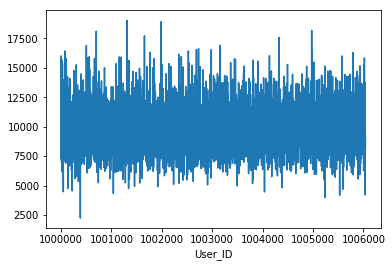

In [203]:
group_by_ID.mean().plot()

### Feature Importance and Sales Prediction

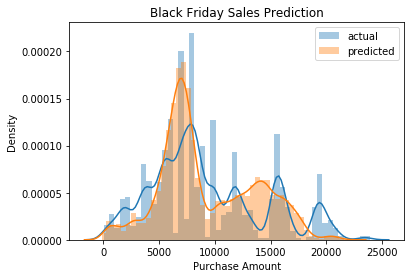

In [57]:
# plot actual and predicted sales data
sns.distplot(Y_test_new, label = 'actual')
sns.distplot(Y_test_pred, label = 'predicted')
plt.legend(loc = 1)
plt.xlabel("Purchase Amount")
plt.ylabel("Density")
plt.title("Black Friday Sales Prediction")
plt.savefig('prediction.png', dpi=300)